In [1]:
import os

import matplotlib.pyplot as plt
import torch
import torch.utils.data

from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''
SEED = 1
BATCH_SIZE = 64
LOG_INTERVAL = 10
EPOCHS = 10
N_SAMPLES = 10
LATENT_DIM = 20
NUM_WORKERS = 2

In [3]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

In [4]:
kwargs = {'num_workers': NUM_WORKERS, 'pin_memory': True} if cuda else {}

In [5]:
# Download or load downloaded MNIST dataset
train_dataset = datasets.MNIST(
    './',
    train=True,
    download=True,
    transform=transforms.Compose([
        #transforms.RandomRotation(30),
        transforms.ToTensor(),
        #transforms.Normalize((0,), (255,)),
    ])
    
)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    **kwargs
)
test_dataset = datasets.MNIST(
    './',
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0,), (255,)),
    ])
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    **kwargs
)

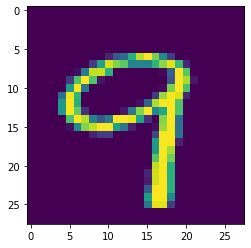

In [6]:
x, y = next(iter(train_loader))
plt.imshow(x[0][0])

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        # Convolutions with same padding
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(4, 4), padding=(15, 15), stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(4, 4), padding=(15, 15), stride=2)
        self.fc_mu = nn.Linear(in_features=16 * 28 * 28, out_features=latent_dim)
        self.fc_logvar = nn.Linear(in_features=16 * 28 * 28, out_features=latent_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(-1, 1, 28, 28)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = x.view(-1, 16 * 28 * 28)
        mu_z = self.fc_mu(x)
        logvar_z = self.fc_logvar(x)
        return mu_z, logvar_z

In [8]:
class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        # Convolutions with same padding
        self.fc1 = nn.Linear(in_features=latent_dim, out_features=128 * 7 * 7)
        self.conv_t1 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, padding=1, stride=2)
        self.conv_t2 = nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, padding=1, stride=2)
        self.relu = nn.ReLU()
        
    def forward(self, z: Variable) -> Variable:
        x = self.relu(self.fc1(z))
        x = x.view(-1, 128, 7, 7)
        x = self.relu(self.conv_t1(x))
        x = torch.sigmoid(self.conv_t2(x))
        return x

In [9]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder, n_samples, latent_dim):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.n_samples = n_samples
        self.latent_dim = latent_dim

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:
        if self.training:
            z_samples = []
            for _ in range(self.n_samples):
                # Multiply log variance with 0.5, then in-place exponent
                # yielding the standard deviation
                std = logvar.mul(0.5).exp()  # type: Variable
                # eps = Variable(std.data.new(std.size()).normal_())
                # Sample a noise term from a standard normal
                eps = torch.randn_like(std)
                z_samples.append(eps.mul(std).add_(mu))
            return z_samples
        # During inference, we simply spit out the mean of the
        # learned distribution for the current input.  We could
        # use a random sample from the distribution, but mu of
        # course has the highest probability.
        return mu
    
    def sample(self, n_samples=1):
        z = Variable(torch.randn(n_samples, self.latent_dim)).to(device)
        return self.decoder.forward(z).cpu()

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encoder.forward(x)
        z = self.reparameterize(mu, logvar)
        if self.training:
            return [self.decoder.forward(z) for z in z], mu, logvar
        return self.decoder.forward(z), mu, logvar

In [10]:
class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, mu, logvar):
        return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / mu.shape[0]


class ReconstructionLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, xhat_samples, x):
        if self.training:
            BCE = 0
            for xhat in xhat_samples:
                BCE += F.binary_cross_entropy(xhat.view(-1, 784), x.view(-1, 784), reduction='sum')
            return BCE / len(xhat_samples) / BATCH_SIZE
        BCE = F.binary_cross_entropy(xhat_samples[0].view(-1, 784), x.view(-1, 784), reduction='sum')

# Training

In [14]:
# Setup
encoder = Encoder(LATENT_DIM)
decoder = Decoder(LATENT_DIM)
model = VAE(encoder, decoder, N_SAMPLES, LATENT_DIM)
model.to(device)

optimizer = optim.Adam(vae.parameters(), lr=1e-4)

kl_divergence_loss = KLDivergenceLoss()
recon_loss = ReconstructionLoss()

In [16]:
for epoch in range(1, EPOCHS + 1):
    # TRAIN
    model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        optimizer.zero_grad()

        x = Variable(x)
        x = x.to(device)

        xhat, mu, logvar = model.forward(x)
        
        rc_loss = recon_loss(xhat, x)
        kl_loss =  kl_divergence_loss(mu, logvar)
        loss = rc_loss + kl_loss

        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tRCLoss: {:.6f}, KLLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(x),
                len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                rc_loss.item(), kl_loss.item()
            ))

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    
    # TEST
    model.eval()
    test_loss = 0
    for i, (data, _) in enumerate(test_loader):
        data = data.to(device)

        # we're only going to infer, so no autograd at all required: volatile=True
        data = Variable(data, volatile=True)
        xhat, mu, logvar = model.forward(data)
        
        rc_loss = recon_loss(xhat, x)
        kl_loss =  kl_divergence_loss(mu, logvar)
        loss = rc_loss + kl_loss

        if i == 0:
            n = min(data.size(0), 8)
            # for the first 128 batch of the epoch, show the first 8 input digits
            # with right below them the reconstructed output digits
            comparison = torch.cat([data[:n], xhat.view(BATCH_SIZE, 1, 28, 28)[:n]])
            save_image(comparison.data.cpu(), './mnist/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(loss))

Train Epoch: 1 [0/60000 (0%)]	RCLoss: 577.580383, KLLoss: 0.007033
Train Epoch: 1 [640/60000 (1%)]	RCLoss: 578.136414, KLLoss: 0.006920
Train Epoch: 1 [1280/60000 (2%)]	RCLoss: 577.196167, KLLoss: 0.006961
Train Epoch: 1 [1920/60000 (3%)]	RCLoss: 577.326904, KLLoss: 0.007015
Train Epoch: 1 [2560/60000 (4%)]	RCLoss: 577.572388, KLLoss: 0.007054
Train Epoch: 1 [3200/60000 (5%)]	RCLoss: 577.918579, KLLoss: 0.006975
Train Epoch: 1 [3840/60000 (6%)]	RCLoss: 578.587280, KLLoss: 0.006914
Train Epoch: 1 [4480/60000 (7%)]	RCLoss: 577.927917, KLLoss: 0.006946


KeyboardInterrupt: 

In [ ]:
xgen = vae.sample()
xgen = xgen.detach().numpy()[0, 0, ...]
plt.imshow(xgen)
xgen.max(), xgen.min(), xgen.mean()

# Tests

In [ ]:
x, y = next(iter(train_loader))
print(x.shape)
print(x.max())
plt.imshow(x[0][0])

In [ ]:
mu, logvar = encoder.forward(x[0, ...])
mu, logvar.exp()

In [ ]:
xhat = decoder.forward(mu)
plt.imshow(xhat.detach().numpy()[0][0])

In [ ]:
xhat, mu, logvar = vae.forward(x)
plt.imshow(xhat[0].detach().numpy()[0][0])